In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_predict, cross_val_score, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline

In [20]:
df = pd.read_csv("../data/ml/ml_ready.csv")

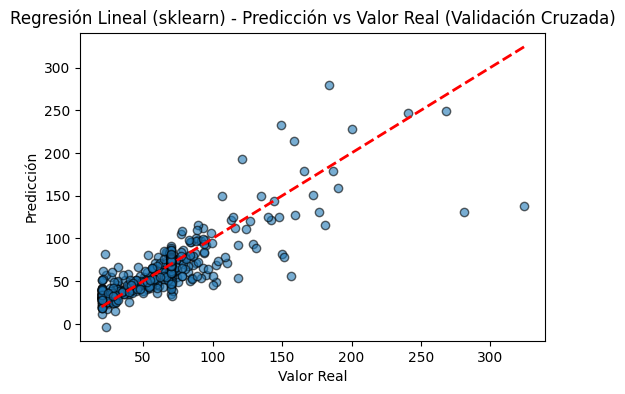

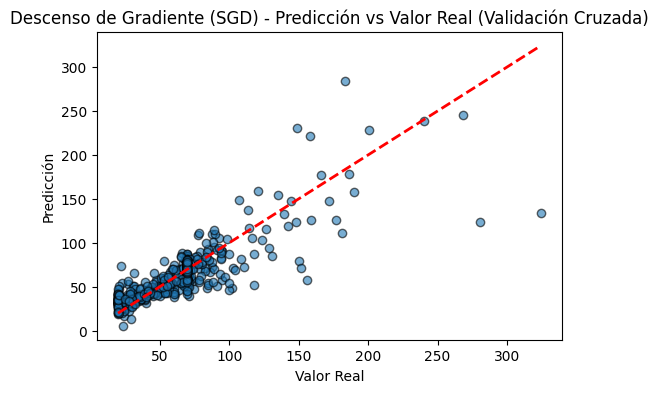

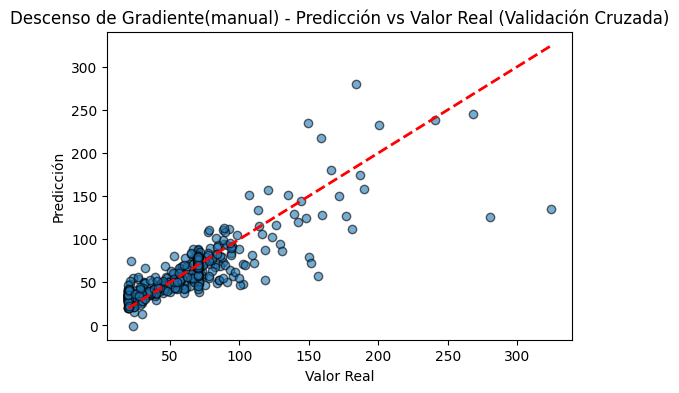

                          Modelo       RMSE        MAE        R2
0     Regresión Lineal (sklearn)  20.394273  12.084157  0.687129
1    Descenso de Gradiente (SGD)  20.444673  12.050822  0.685506
2  Descenso de Gradiente(manual)  20.316234  11.946726  0.689145

[Regresión Lineal (sklearn)]
Coeficientes: [  0.25772116  -7.89744669   4.63860603  -1.55395054   1.65965289
   1.65965289  11.69335112 -18.7591761    5.54150258  50.43641321
  -6.79441481   0.4762113   -3.85793353  -3.85793353   9.52613074
   0.25772116  -0.40111713  15.00973587 -14.35326351 -10.12401522
  10.12401522  -6.59092041]
Intercepto: 62.35950699400435

[Descenso de Gradiente (SGD)]
Coeficientes: [  0.17807809  -2.56751909  -2.39866234  -0.69155774   1.07256866
   1.07256866   0.17936208  -5.18808684   3.59771714  12.4707753
  11.11165586  -0.19508757  -3.85189476  -3.85189476   9.61829424
   0.17807809  -0.11445768   1.82411248  -1.08580173 -10.18193591
  10.18193591  10.89774376]
Intercepto: [62.24185269]

[Descenso d

In [21]:
# me decía que la matriz no era inversible asi que no hay como hacer la regresión manual

class ManualGradientDescent(BaseEstimator, RegressorMixin):
    def __init__(self, learning_rate=0.01, n_iter=1000):
        self.learning_rate = learning_rate
        self.n_iter = n_iter

    def fit(self, X, y):
        m, n = X.shape

        X_b = np.c_[np.ones((m, 1)), X]
        
        self.theta_ = np.random.randn(n + 1)
        
        #bucle principal de descenso de gradiente
        for i in range(self.n_iter):
            gradients = 2/m * X_b.T.dot(X_b.dot(self.theta_) - y)
            self.theta_ -= self.learning_rate * gradients

        # guardamos intercept_ y coef_
        self.intercept_ = self.theta_[0]
        self.coef_ = self.theta_[1:]
        return self

    def predict(self, X):
        X_b = np.c_[np.ones((X.shape[0], 1)), X]
        return X_b.dot(self.theta_)


X = df.drop(columns=['total_pagos_promedios'])
y = df['total_pagos_promedios']

#pipelines para cada modelo (incluyendo los manuales)
pipeline_lr = Pipeline([
    ("scaler", StandardScaler()),
    ("regressor", LinearRegression())
])

pipeline_sgd = Pipeline([
    ("scaler", StandardScaler()),
    ("regressor", SGDRegressor(max_iter=1000, tol=1e-3, random_state=42))
])

pipeline_manual_gd = Pipeline([
    ("scaler", StandardScaler()),
    ("regressor", ManualGradientDescent(learning_rate=0.01, n_iter=1000))
])

models = {
    "Regresión Lineal (sklearn)": pipeline_lr,
    "Descenso de Gradiente (SGD)": pipeline_sgd,
    "Descenso de Gradiente(manual)": pipeline_manual_gd
}

#configuramos la validación cruzada
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

results = []

for name, model in models.items():
    #cross_val_predict para predecir en cada fold
    y_pred = cross_val_predict(model, X, y, cv=kfold)
    
    #cross_val_score para calcular métricas por fold y luego promediarlas
    mse_scores = -cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=kfold)
    mae_scores = -cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=kfold)
    r2_scores  =  cross_val_score(model, X, y, scoring='r2', cv=kfold)

    #promedio de cada métrica
    rmse = np.sqrt(mse_scores.mean())
    mae = mae_scores.mean()
    r2 = r2_scores.mean()
    
    results.append({'Modelo': name, 'RMSE': rmse, 'MAE': mae, 'R2': r2})
    
    #visualización
    plt.figure(figsize=(6, 4))
    plt.scatter(y, y_pred, alpha=0.6, edgecolor='k')
    plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', linewidth=2)
    plt.title(f"{name} - Predicción vs Valor Real (Validación Cruzada)")
    plt.xlabel("Valor Real")
    plt.ylabel("Predicción")
    plt.show()
    

# DataFrame con métricas finales
df_results = pd.DataFrame(results)
print(df_results)

# Ahora, para ver coeficientes e interceptos de cada modelo,
# primero ajustamos cada pipeline a TODOS los datos (fit "final"):
pipeline_lr.fit(X, y)
pipeline_sgd.fit(X, y)
pipeline_manual_gd.fit(X, y)

#regresion lineal (sklearn)
coeficientes_lr = pipeline_lr.named_steps["regressor"].coef_
intercepto_lr   = pipeline_lr.named_steps["regressor"].intercept_
print("\n[Regresión Lineal (sklearn)]")
print("Coeficientes:", coeficientes_lr)
print("Intercepto:", intercepto_lr)

# sgd
coeficientes_sgd = pipeline_sgd.named_steps["regressor"].coef_
intercepto_sgd   = pipeline_sgd.named_steps["regressor"].intercept_
print("\n[Descenso de Gradiente (SGD)]")
print("Coeficientes:", coeficientes_sgd)
print("Intercepto:", intercepto_sgd)

# descenso de gradiente (manual)
coeficientes_mgd = pipeline_manual_gd.named_steps["regressor"].coef_
intercepto_mgd   = pipeline_manual_gd.named_steps["regressor"].intercept_
print("\n[Descenso de Gradiente (manual)]")
print("Coeficientes:", coeficientes_mgd)
print("Intercepto:", intercepto_mgd)


Estos resultados indican que todos los modelos están prediciendo de forma muy parecida, ya que tanto el RMSE como el MAE son muy similares en cada caso. Además, el R² cercano a 0.68 significa que los modelos explican alrededor de dos tercios de la variabilidad de la variable objetivo; en consecuencia, todavía hay cerca de un 30% de la variación que no están capturando. Este porcentaje no explicado podría mejorarse añadiendo características adicionales, aplicando transformaciones apropiadas o evaluando otros enfoques de modelado (como modelos no lineales).

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 23 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Unnamed: 0.1                          500 non-null    int64  
 1   total_calls                           500 non-null    float64
 2   total_minutes                         500 non-null    float64
 3   promedio_minutes_por_ocasion          500 non-null    float64
 4   extra_minutes                         500 non-null    float64
 5   extra_charges_minutes                 500 non-null    float64
 6   total_internet                        500 non-null    float64
 7   total_mb                              500 non-null    float64
 8   promedio_mb_por_ocasion               500 non-null    float64
 9   extra_mb                              500 non-null    float64
 10  extra_charges_gb                      500 non-null    float64
 11  total_messages     